In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import Affine2D
from matplotlib.lines import Line2D

In [3]:
# Metadata saved to output plots
METADATA = {"Contributor": "Alexander Gude", "Rights": "CC-BY-SA 4.0"}

In [4]:
# Show plots inline
%matplotlib inline

In [5]:
COLORS = {
    "zillow": "#006AFF",
    "redfin": "#E62E2E",
    "xome": "#FF5C39",
    "realtor.com": "purple",
}

MARKERS = {
    "zillow": "^",
    "redfin": "o",
    "xome": "*",
    "realtor.com": "D",
}

# Helper functions

In [6]:
# We should be able to just set rcParams, expect Jupyter has a bug:
# https://github.com/jupyter/notebook/issues/3385
#
# So we have to call this function every time we want to plot.


def setup_plot(title=None, xlabel=None, ylabel=None):
    """Set up a simple, single pane plot with custom configuration.

    Args:
        title (str, optional): The title of the plot.
        xlabel (str, optional): The xlabel of the plot.
        ylabel (str, optional): The ylabel of the plot.

    Returns:
        (fig, ax): A Matplotlib figure and axis object.

    """
    # Plot Size
    plt.rcParams["figure.figsize"] = (12, 7)  # (Width, height)

    # Text Size
    SMALL = 12
    MEDIUM = 16
    LARGE = 20
    HUGE = 28
    plt.rcParams["axes.titlesize"] = HUGE
    plt.rcParams["figure.titlesize"] = HUGE
    plt.rcParams["axes.labelsize"] = LARGE
    plt.rcParams["legend.fontsize"] = LARGE
    plt.rcParams["xtick.labelsize"] = MEDIUM
    plt.rcParams["ytick.labelsize"] = MEDIUM
    plt.rcParams["font.size"] = SMALL

    # Legend
    plt.rcParams["legend.frameon"] = True
    plt.rcParams["legend.framealpha"] = 1
    plt.rcParams["legend.facecolor"] = "white"
    plt.rcParams["legend.edgecolor"] = "black"

    # Figure output
    plt.rcParams["savefig.dpi"] = 300

    # Plot colors
    plt.rcParams["figure.facecolor"] = "white"

    # Make the plol
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Make the title and label area opaque instead of transparent
    fig.patch.set_facecolor(ax.get_facecolor())

    return fig, ax

In [7]:
def draw_colored_legend(ax, loc="best"):
    """Draw a legend for the plot with the text colored to match the points.

    Args:
        ax (matplotlib axis): The axis to draw on.

    """
    # Draw a legend where there is no space around the line/point so
    # that the text is in the right place when we turn off the line/point.
    legend = ax.legend(handlelength=0, handletextpad=0, loc=loc)

    handles = legend.legendHandles
    texts = legend.get_texts()
    for handle, text in zip(handles, texts):
        # Change the color of the text to match the line or points
        try:
            # Points and some other objects have this
            color = handle.get_facecolor()[0]
        except AttributeError:
            # Lines have this
            color = handle.get_color()

        text.set_color(color)

        # Turn off the point
        handle.set_visible(False)

In [8]:
def save_plot(fig, filename):
    """Save the plot with metadata and tight layout.

    Args:
        fig (matplotlib figure): The figure to save.
        filename (str): The loction to save the file to.

    """
    metadata = METADATA

    fig.savefig(
        fname=f"{filename}",
        bbox_inches="tight",
        metadata=metadata,
    )

In [9]:
def number_formatter(number, pos=None):
    """Convert a number into a human readable format.

    Via https://flynn.gg/blog/better-matplotlib-charts/"""
    number /= 1000.0

    return f"${number:,.0f}K"

# Data

In [10]:
df = (
    pd.read_json("./home_price_estimate_20220701.json", orient="table")
    .sort_values(["date", "website"])
    .reset_index(drop=True)
)


LIST_PRICE = 1_150_000
LIST_DATE = "2022-04-21"

PENDING_DATE = "2022-04-27"
PENDING_DATE_AXIS = "2022-04-30"

SOLD_PRICE = 1_175_000
SOLD_DATE = "2022-05-26"

In [11]:
companies_df = df[df["website"].isin(["zillow", "redfin", "realtor.com"])]

companies_df

,index,date,prediction_date,amount,amount_high,amount_low,source,error_low,error_high,website
0,0,2022-04-11 01:24:32,NaT,1027400.00,NaN,NaN,NaN,NaN,NaN,zillow
1,0,2022-04-11 01:24:36,NaT,1156960.86,NaN,NaN,NaN,NaN,NaN,redfin
2,0,2022-04-11 01:24:40,2022-03-31,1104300.00,1268500.0,940200.0,corelogic,164100.0,164200.0,realtor.com
3,1,2022-04-11 07:03:45,NaT,1035800.00,NaN,NaN,NaN,NaN,NaN,zillow
4,1,2022-04-11 07:03:49,NaT,1156960.86,NaN,NaN,NaN,NaN,NaN,redfin
...,...,...,...,...,...,...,...,...,...,...
204,67,2022-06-17 07:04:27,NaT,1200096.93,NaN,NaN,NaN,NaN,NaN,redfin
205,68,2022-06-17 07:04:31,2022-06-12,1204900.00,1292800.0,1116900.0,corelogic,88000.0,87900.0,realtor.com
206,69,2022-06-18 07:04:11,NaT,1181300.00,NaN,NaN,NaN,NaN,NaN,zillow
207,68,2022-06-18 07:04:15,NaT,1200096.93,NaN,NaN,NaN,NaN,NaN,redfin


In [12]:
company_names = {c.capitalize() for c in companies_df["website"]}

company_names

{'Realtor.com', 'Redfin', 'Zillow'}

# Plotting

In [13]:
COMPANY_Y_LOCATIONS = {
    "zillow": 1_047_000,
    "redfin": 1_200_000,
    "xome": None,
    "realtor.com": 1_074_000,
}

Z_LEVEL = {
    "zillow": 1,
    "redfin": 1,
    "xome": None,
    "realtor.com": 0,
}

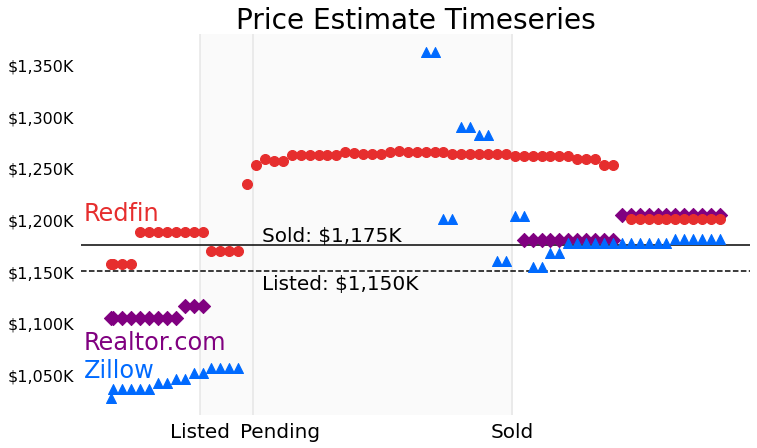

In [14]:
fig, ax = setup_plot("Price Estimate Timeseries")

# Format y-axis for dollars
ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))

# Scatter plot uses a different size that is the square of the marker size
marker_size = 10
scatter_size = marker_size**2

# Plot estimates
legend_x_date = pd.to_datetime("2022-04-08")
for company_name in company_names:

    color = COLORS[company_name.lower()]
    marker = MARKERS[company_name.lower()]
    z_level = Z_LEVEL[company_name.lower()]
    y_location_for_text = COMPANY_Y_LOCATIONS[company_name.lower()]

    company_df = companies_df[companies_df["website"] == company_name.lower()]

    ax.scatter(
        x=company_df["date"].values,
        y=company_df["amount"].values,
        color=color,
        s=scatter_size,
        label=company_name,
        marker=marker,
        zorder=z_level,
    )

    ax.text(
        x=legend_x_date,
        y=y_location_for_text,
        s=company_name,
        fontsize=24,
        color=color,
    )

# Draw list and sales prices
ax.axhline(y=LIST_PRICE, color="black", zorder=-1, linestyle="dashed")
ax.axhline(y=SOLD_PRICE, color="black", zorder=-1)

text_x_date = pd.to_datetime("2022-04-28")
ax.text(
    x=text_x_date,
    y=LIST_PRICE - 3000,
    s=f"Listed: ${round(LIST_PRICE/1000):,.0f}K",
    fontsize=20,
    verticalalignment="top",
)
ax.text(
    x=text_x_date,
    y=SOLD_PRICE,
    s=f"Sold: ${round(SOLD_PRICE/1000):,.0f}K",
    fontsize=20,
    verticalalignment="bottom",
)

# Drawing list, pending, and sold dates
ax.axvline(x=pd.to_datetime(LIST_DATE), color="0.9", zorder=-2)
ax.axvline(x=pd.to_datetime(PENDING_DATE), color="0.9", zorder=-2)
ax.axvline(x=pd.to_datetime(SOLD_DATE), color="0.9", zorder=-2)

ax.axvspan(
    pd.to_datetime(LIST_DATE),
    pd.to_datetime(PENDING_DATE),
    color="0.98",
    zorder=-3,
)

ax.axvspan(
    pd.to_datetime(PENDING_DATE),
    pd.to_datetime(SOLD_DATE),
    color="0.98",
    zorder=-3,
)

# Adjust x-axis labels
ax.xaxis.set_ticks_position("none")  # Remove the line from ticks
ax.yaxis.set_ticks_position("none")

ax.set_xticks([LIST_DATE, PENDING_DATE_AXIS, SOLD_DATE])
ax.set_xticklabels(["Listed", "Pending", "Sold"])
ax.tick_params(axis="x", labelsize=20)

sns.despine(top=True, bottom=True, left=True, right=True)

for ext in ("png", "svg"):
    save_plot(fig, f"/tmp/home_price_estimate_timeseries_comparison_automated.{ext}")